In [1]:
import sys
sys.path.append('../')

import numpy as np
#from scipy import ndimage

from skimage.filters import sobel_h
from skimage.filters import sobel_v
#from scipy import stats


import os
import matplotlib
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.python.client import device_lib

#plt.rcParams['figure.figsize'] = [10,10]

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications import VGG16

from tensorflow.nn import depthwise_conv2d
from tensorflow.math import multiply, reduce_sum, reduce_mean,reduce_euclidean_norm, sin, cos, abs
from tensorflow import stack, concat, expand_dims

import tensorflow_probability as tfp

from utils.utils import *
from scipy.fft import dct, idct

plt.style.use(['science', 'ieee'])
plt.rcParams.update({'figure.dpi': '100'})

#### Experiment #1 : Confirming that most energy lies within the first 3 DCT coeficients

In [2]:
model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

In [22]:
k = 5 # Top 10% highest l2-magnitude filters

In [23]:
conv_layers = []
for l in model.layers:
    if 'conv2d' in str(type(l)).lower():
        conv_layers.append(l)

top3_coef_mag = []
kernel_mag = []


top10F=topKfilters(model, 10, k=k)
filters = get_filter(model, 10)[:,:,:, top10F]
dct_out = dct2(filters[:,:,0, 0])



for l_num in range(1, len(conv_layers)):
    print(l_num)
    top10F=topKfilters(model, l_num, k=k)
    filters = get_filter(model, l_num)[:,:,:, top10F]
    for i in range(filters.shape[-1]):
        for j in range(filters.shape[-2]):
            kernel = filters[:,:, j,i]
            #print(kernel.shape)
            dct_out = dct2(kernel)
            top3_coef_mag.append((reduce_euclidean_norm([dct_out[0,0],dct_out[0,1],dct_out[1,0]])))
            kernel_mag.append(reduce_euclidean_norm(dct_out))

print(reduce_euclidean_norm(dct_out))
print(reduce_euclidean_norm(filters[:,:,0, 0]))

print((reduce_euclidean_norm([dct_out[0,0],dct_out[0,1],dct_out[1,0]])) / reduce_euclidean_norm(dct_out))



dct_out

1
2
3
4
5
6
7
8
9
10
11
12
tf.Tensor(0.017012632, shape=(), dtype=float32)
tf.Tensor(0.021696052, shape=(), dtype=float32)
tf.Tensor(0.9581636, shape=(), dtype=float32)


array([[-7.9566855e-03, -4.6330676e-03, -1.7277539e-03],
       [ 1.3451568e-02, -5.6666438e-04, -3.6378938e-03],
       [-8.5645690e-05,  2.2957658e-03, -1.3756524e-03]], dtype=float32)

In [28]:
np.mean((np.array(kernel_mag) - np.array(top3_coef_mag)) / np.array(kernel_mag))

0.17404151

In [13]:
dct_im = np.float16([[0,0,0], [0,1,0], [0,0,0]])
im = idct2(dct_im)
im

array([[ 5.0000006e-01,  0.0000000e+00, -5.0000006e-01],
       [-2.1073426e-08,  8.8817842e-16,  2.1073426e-08],
       [-5.0000006e-01,  0.0000000e+00,  5.0000006e-01]], dtype=float32)

In [ ]:
np.ones((3,3))

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [ ]:
dct2(np.ones((3,3)0

array([[10.39230485,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [2]:
np.eye(3)

NameError: name 'np' is not defined

In [1]:
im

NameError: name 'im' is not defined

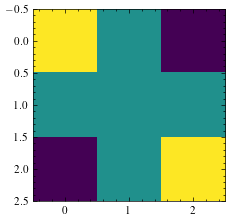

In [14]:
plt.imshow(im)